In [14]:
import pandas as pd

# Load the Parquet file
df1 = pd.read_parquet('../data/raw/filtered_rental_listings_old.parquet')
df2 = pd.read_parquet('../data/raw/filtered_rental_listings_new.parquet')
combined_df = pd.concat([df1, df2], ignore_index=True)


In [15]:
df = combined_df

# Convert 'dateListed' to datetime
df['dateListed'] = pd.to_datetime(df['dateListed'])

# Extract year from 'dateListed'
df['year'] = df['dateListed'].dt.year

# Count number of listings per year
listings_per_year = df.groupby('year').size().reset_index(name='number_of_listings')

# Print results
print(listings_per_year)

    year  number_of_listings
0   2004                 777
1   2005                8072
2   2006                7278
3   2007                8326
4   2008                9452
5   2009                7217
6   2010                3972
7   2011                5416
8   2012               10404
9   2013               11262
10  2014                9852
11  2015               10464
12  2016                7977
13  2017                3338
14  2018                4579
15  2019               17189
16  2020               18289
17  2021               14361
18  2022               14325
19  2023               14877
20  2024               12064


In [16]:
import pandas as pd

# Select only the important columns
selected_columns = [
    'addressParts.displayAddress',  # Full address
    'addressParts.stateAbbreviation', 
    'addressParts.suburb', 
    'bedrooms',                     # Number of bedrooms
    'bathrooms',                    # Number of bathrooms
    'propertyTypes',
    'carspaces',                    # Number of car spaces
    'dateListed',                   # Listing date
    'geoLocation.latitude',         # Latitude
    'geoLocation.longitude',        # Longitude
    'isNewDevelopment',             # New development flag
    'priceDetails.price',           # Price of the listing
    'description',                  # Description of the listing
    'features',                      # Features list
    'rentalDetails.leasedDate'      # Leased date
]

# Filter the DataFrame with the selected columns
selected_df = combined_df[selected_columns]

# Rename columns for easier access
selected_df = selected_df.rename(columns={
    'addressParts.displayAddress': 'address',
    'addressParts.stateAbbreviation': 'state',
    'addressParts.suburb': 'suburb',
    'dateListed': 'date_listed',
    'geoLocation.latitude': 'latitude',
    'geoLocation.longitude': 'longitude',
    'isNewDevelopment': 'is_new_development',
    'priceDetails.price': 'price',
    'rentalDetails.leasedDate': 'leased_date'
    
})

# Feature Engineering: Add a new column 'is_furnished'
# 1. Check if the description mentions "furnished" but not "unfurnished"
# 2. Check if the word "Furnished" exists in the features list
def is_furnished(description, features):
    # Check if "furnished" appears in the description but "unfurnished" does not
    desc_furnished = 'furnished' in description.lower() and 'unfurnished' not in description.lower() if isinstance(description, str) else False
    # Check if "Furnished" exists in the features list
    features_furnished = 'Furnished' in features if isinstance(features, list) else False
    # Return True if either condition is True
    return desc_furnished or features_furnished

# Apply the function to create the 'is_furnished' column
selected_df['is_furnished'] = selected_df.apply(lambda row: is_furnished(row['description'], row['features']), axis=1)

# Drop the 'description' and 'features' columns as they are no longer needed
selected_df = selected_df.drop(columns=['description', 'features'])

# Display the first few rows to verify
print(selected_df.head())




                                             address state  \
0            1201/55 Queens Road, Melbourne VIC 3000   vic   
1   211/G04K Powlett Street, East Melbourne VIC 3002   vic   
2                                       Rye VIC 3941   vic   
3  1204/454 St Kilda Road, Melbourne St Kilda Roa...   vic   
4    211 Wellington Pde Sth, East Melbourne VIC 3002   vic   

                    suburb  bedrooms  bathrooms        propertyTypes  \
0                Melbourne       2.0        2.0  [apartmentUnitFlat]   
1           East Melbourne       3.0        2.0  [apartmentUnitFlat]   
2                      Rye       3.0        2.0              [house]   
3  Melbourne St Kilda Road       3.0        3.0  [apartmentUnitFlat]   
4           East Melbourne       3.0        3.0  [apartmentUnitFlat]   

   carspaces               date_listed   latitude   longitude  \
0        2.0 2009-05-08 01:26:01+00:00 -37.847967  144.977640   
1        1.0 2009-05-08 01:26:03+00:00 -37.812575  144.985854   

In [17]:
selected_df = selected_df[selected_df['state'] == "vic"]
selected_df.count()

address               196908
state                 196908
suburb                196908
bedrooms              196908
bathrooms             196908
propertyTypes         196898
carspaces             196908
date_listed           196908
latitude              191569
longitude             191569
is_new_development    196908
price                 196908
leased_date            78406
is_furnished          196908
dtype: int64

In [18]:
# Extract the year from 'date_listed' for the entire DataFrame
selected_df['year'] = pd.to_datetime(selected_df['date_listed']).dt.year

# Count the total number of listings per year
total_listings_per_year = selected_df.groupby('year').size().reset_index(name='total_listings')

# Check for listings without a 'leasedDate' (NaN or empty)
listings_without_leased_date = selected_df[selected_df['leased_date'].isna() | (selected_df['leased_date'] == '')]

# Count the number of listings per year without 'leasedDate'
listings_per_year_without_leased_date = listings_without_leased_date.groupby('year').size().reset_index(name='number_of_listings_without_leased_date')

# Merge the two DataFrames on 'year' to get both total listings and listings without 'leasedDate'
merged_df = pd.merge(total_listings_per_year, listings_per_year_without_leased_date, on='year', how='left')

# Fill NaN values with 0 for years that have no missing 'leasedDate' entries
merged_df['number_of_listings_without_leased_date'] = merged_df['number_of_listings_without_leased_date'].fillna(0)

# Print the merged DataFrame
print(merged_df)


    year  total_listings  number_of_listings_without_leased_date
0   2004             777                                     770
1   2005            8071                                    8057
2   2006            7278                                    7277
3   2007            8326                                    8324
4   2008            9452                                    9375
5   2009            7217                                    6780
6   2010            3972                                    3677
7   2011            5415                                    5124
8   2012           10404                                   10024
9   2013           11261                                   10842
10  2014            9852                                    9525
11  2015           10464                                    5053
12  2016            7687                                    2741
13  2017            2556                                    1954
14  2018            4521 

In [19]:
# Ensure 'dateListed' is in datetime format
selected_df['date_listed'] = pd.to_datetime(selected_df['date_listed'])

# Extract only the date (without time)
selected_df['date_listed'] = selected_df['date_listed'].dt.date

# Add columns for year, month, and day
selected_df['year'] = pd.DatetimeIndex(selected_df['date_listed']).year
selected_df['month'] = pd.DatetimeIndex(selected_df['date_listed']).month
selected_df['day'] = pd.DatetimeIndex(selected_df['date_listed']).day

# Display the first few rows to verify
print(selected_df[['date_listed', 'year', 'month', 'day']].head())

  date_listed  year  month  day
0  2009-05-08  2009      5    8
1  2009-05-08  2009      5    8
2  2009-05-08  2009      5    8
3  2009-05-11  2009      5   11
4  2009-05-11  2009      5   11


In [20]:
# Ensure 'date_listed' is in datetime format
selected_df['date_listed'] = pd.to_datetime(selected_df['date_listed'])

# Define the cutoff date
cutoff_date = pd.to_datetime('2024-09-08')

# Filter the DataFrame to include only rows where 'date_listed' is less than or equal to the cutoff date
filtered_df = selected_df[selected_df['date_listed'] <= cutoff_date]

In [21]:
# Convert 'date_listed' and 'leased_date' to datetime
selected_df['date_listed'] = pd.to_datetime(selected_df['date_listed'], errors='coerce')
selected_df['leased_date'] = pd.to_datetime(selected_df['leased_date'], errors='coerce')

# Calculate the number of days the listing was on the market (if leased_date is present)
selected_df['days_on_market'] = (selected_df['leased_date'] - selected_df['date_listed']).dt.days

In [22]:
import pandas as pd

# Ensure 'leased_date' and 'date_listed' are in datetime format
selected_df['leased_date'] = pd.to_datetime(selected_df['leased_date'], errors='coerce')
selected_df['date_listed'] = pd.to_datetime(selected_df['date_listed'], errors='coerce')

# Calculate 'days_on_market' for listings with both 'leased_date' and 'date_listed'
selected_df['days_on_market'] = (selected_df['leased_date'] - selected_df['date_listed']).dt.days

# Extract the year from 'date_listed' for the entire DataFrame
selected_df['year'] = selected_df['date_listed'].dt.year

# Filter listings that took longer than 200 days to lease
long_listing_df = selected_df[selected_df['days_on_market'] > 200]

# Count the number of listings per year that took longer than 200 days to lease
long_listings_per_year = long_listing_df.groupby('year').size().reset_index(name='number_of_long_listings')

# Merge with total listings per year to get the context
merged_long_df = pd.merge(total_listings_per_year, long_listings_per_year, on='year', how='left')

# Fill NaN values with 0 for years with no long listings
merged_long_df['number_of_long_listings'] = merged_long_df['number_of_long_listings'].fillna(0)

# Print the merged DataFrame
print(merged_long_df)


    year  total_listings  number_of_long_listings
0   2004             777                      0.0
1   2005            8071                      2.0
2   2006            7278                      0.0
3   2007            8326                      2.0
4   2008            9452                      3.0
5   2009            7217                      8.0
6   2010            3972                     20.0
7   2011            5415                     19.0
8   2012           10404                     30.0
9   2013           11261                     64.0
10  2014            9852                     87.0
11  2015           10464                     84.0
12  2016            7687                     78.0
13  2017            2556                     32.0
14  2018            4521                     37.0
15  2019           16137                     75.0
16  2020           18103                    200.0
17  2021           14319                    144.0
18  2022           14229                    133.0


In [23]:
# Filter listings that have a non-null 'leased_date'
listings_with_leased_date = selected_df[selected_df['leased_date'].notna()]

# Count the number of non-null listings per year
listings_with_leased_date_per_year = listings_with_leased_date.groupby('year').size().reset_index(name='number_of_listings_with_leased_date')

# Merge with the total listings per year for comparison
merged_leased_date_df = pd.merge(total_listings_per_year, listings_with_leased_date_per_year, on='year', how='left')

# Fill NaN values with 0 for years with no listings that have a 'leased_date'
merged_leased_date_df['number_of_listings_with_leased_date'] = merged_leased_date_df['number_of_listings_with_leased_date'].fillna(0)

# Print the merged DataFrame
print(merged_leased_date_df)


    year  total_listings  number_of_listings_with_leased_date
0   2004             777                                  6.0
1   2005            8071                                  8.0
2   2006            7278                                  0.0
3   2007            8326                                  2.0
4   2008            9452                                 74.0
5   2009            7217                                432.0
6   2010            3972                                293.0
7   2011            5415                                291.0
8   2012           10404                                380.0
9   2013           11261                                419.0
10  2014            9852                                327.0
11  2015           10464                               5411.0
12  2016            7687                               4946.0
13  2017            2556                                602.0
14  2018            4521                               2269.0
15  2019

In [24]:
selected_df.count()

address               196908
state                 196908
suburb                196908
bedrooms              196908
bathrooms             196908
propertyTypes         196898
carspaces             196908
date_listed           196908
latitude              191569
longitude             191569
is_new_development    196908
price                 196908
leased_date            78388
is_furnished          196908
year                  196908
month                 196908
day                   196908
days_on_market         78388
dtype: int64

In [25]:
# Check for negative values in 'days_on_market'
negative_days = selected_df[selected_df['days_on_market'] < 0]

# Display the rows with negative 'days_on_market' values
print(f"Number of rows with negative 'days_on_market': {len(negative_days)}")
print(negative_days)

# Optionally, remove these rows from the DataFrame if they are not needed
# selected_df = selected_df[selected_df['days_on_market'] >= 0]

Number of rows with negative 'days_on_market': 335
                                             address state           suburb  \
4044        5/16 Cromwell Road, South Yarra VIC 3141   vic      South Yarra   
4058       5/46 Darling Street, South Yarra VIC 3141   vic      South Yarra   
4067     19/51 Caroline Street, South Yarra VIC 3141   vic      South Yarra   
4069           6/33 Orange Grove, Balaclava VIC 3183   vic        Balaclava   
4076      2B Napier Street, South Melbourne VIC 3205   vic  South Melbourne   
...                                              ...   ...              ...   
189483          86 Donnybrook Road, Norlane VIC 3214   vic          Norlane   
189489       5 Logan Street, Hamlyn Heights VIC 3215   vic   Hamlyn Heights   
189493           3/2 Bayley Street, Geelong VIC 3220   vic          Geelong   
191392  13 Peppercress Street, Diggers Rest VIC 3427   vic     Diggers Rest   
193579      402 Barkers Road, Hawthorn East VIC 3123   vic    Hawthorn East   



In [25]:
# Optionally, remove these rows from the DataFrame if they are not needed
modified_df = selected_df
modified_df2 = selected_df[selected_df['days_on_market'] >= 300]
print(modified_df2.count())

print(modified_df["days_on_market"].mean()) 
print(modified_df["days_on_market"].median()) 
print(modified_df["days_on_market"].max()) 

address               813
state                 813
suburb                813
bedrooms              813
bathrooms             813
propertyTypes         813
carspaces             813
date_listed           813
latitude              812
longitude             812
is_new_development    813
price                 813
leased_date           813
is_furnished          813
year                  813
month                 813
day                   813
days_on_market        813
dtype: int64
37.86415640654427
22.0
3139.0


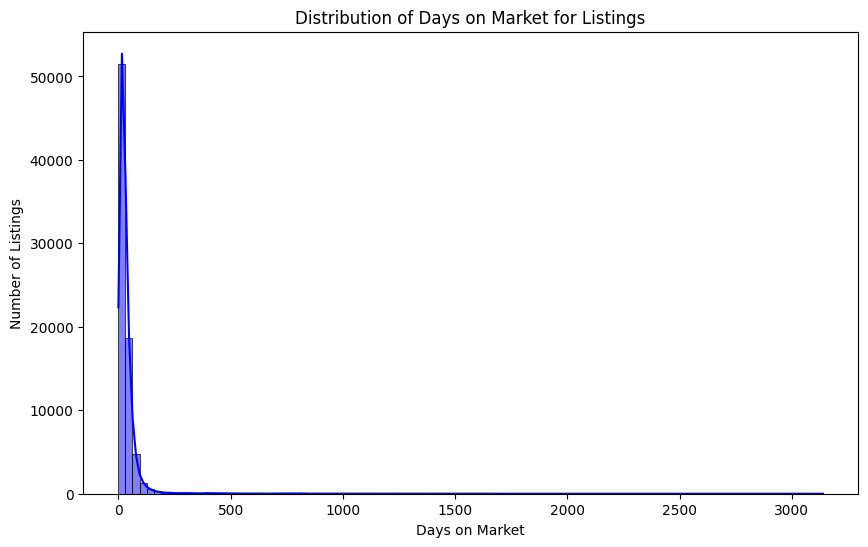

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plot
plt.figure(figsize=(10, 6))

# Plot the distribution of 'days_on_market'
sns.histplot(data=modified_df, x='days_on_market', bins=100, kde=True, color='blue')

# Add titles and labels
plt.title('Distribution of Days on Market for Listings')
plt.xlabel('Days on Market')
plt.ylabel('Number of Listings')

# Show the plot
plt.show()


/tmp/ipykernel_1712/3989790481.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  modified_df['year_listed'] = pd.to_datetime(modified_df['date_listed']).dt.year


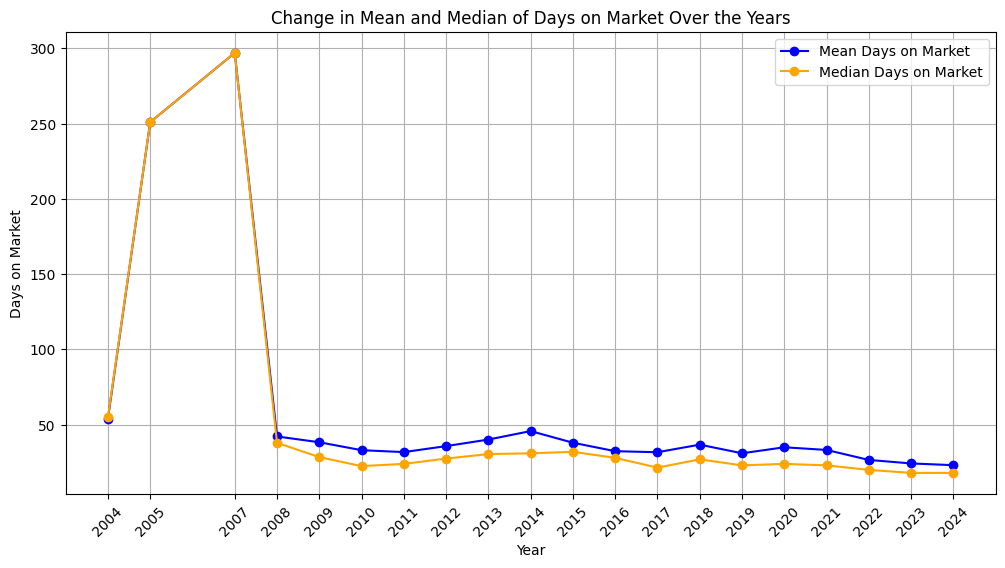

In [27]:
import matplotlib.pyplot as plt

modified_df = selected_df[(selected_df['days_on_market'] >= 0) & (selected_df['days_on_market'] <= 300)]

# Step 1: Extract the year from the 'date_listed' column
modified_df['year_listed'] = pd.to_datetime(modified_df['date_listed']).dt.year

# Step 3: Group by year and calculate mean and median of 'days_on_market'
yearly_stats = modified_df.groupby('year_listed')['days_on_market'].agg(['mean', 'median']).reset_index()

# Step 4: Plot the change in mean and median over the years
plt.figure(figsize=(12, 6))

# Plot mean
plt.plot(yearly_stats['year_listed'], yearly_stats['mean'], marker='o', label='Mean Days on Market', color='blue')
# Plot median
plt.plot(yearly_stats['year_listed'], yearly_stats['median'], marker='o', label='Median Days on Market', color='orange')

# Adding titles and labels
plt.title('Change in Mean and Median of Days on Market Over the Years')
plt.xlabel('Year')
plt.ylabel('Days on Market')
plt.xticks(yearly_stats['year_listed'], rotation=45)
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [17]:


# Calculate the median of 'days_on_market' after removing negative values
median_days_on_market = selected_df['days_on_market'].median()

# Fill missing values in 'days_on_market' with the median
selected_df['days_on_market'] = selected_df['days_on_market'].fillna(median_days_on_market)

# selected_df = selected_df[selected_df['days_on_market'] <= 365]

# Display the first few rows to verify
print(selected_df.head())


                                             address state  \
0            1201/55 Queens Road, Melbourne VIC 3000   vic   
1   211/G04K Powlett Street, East Melbourne VIC 3002   vic   
2                                       Rye VIC 3941   vic   
3  1204/454 St Kilda Road, Melbourne St Kilda Roa...   vic   
4    211 Wellington Pde Sth, East Melbourne VIC 3002   vic   

                    suburb  bedrooms  bathrooms        propertyTypes  \
0                Melbourne       2.0        2.0  [apartmentUnitFlat]   
1           East Melbourne       3.0        2.0  [apartmentUnitFlat]   
2                      Rye       3.0        2.0              [house]   
3  Melbourne St Kilda Road       3.0        3.0  [apartmentUnitFlat]   
4           East Melbourne       3.0        3.0  [apartmentUnitFlat]   

   carspaces date_listed   latitude   longitude  is_new_development   price  \
0        2.0  2009-05-08 -37.847967  144.977640               False  1000.0   
1        1.0  2009-05-08 -37.812575 

In [26]:
selected_df.count()

address               196908
state                 196908
suburb                196908
bedrooms              196908
bathrooms             196908
propertyTypes         196898
carspaces             196908
date_listed           196908
latitude              191569
longitude             191569
is_new_development    196908
price                 196908
leased_date            78388
is_furnished          196908
year                  196908
month                 196908
day                   196908
days_on_market         78388
dtype: int64

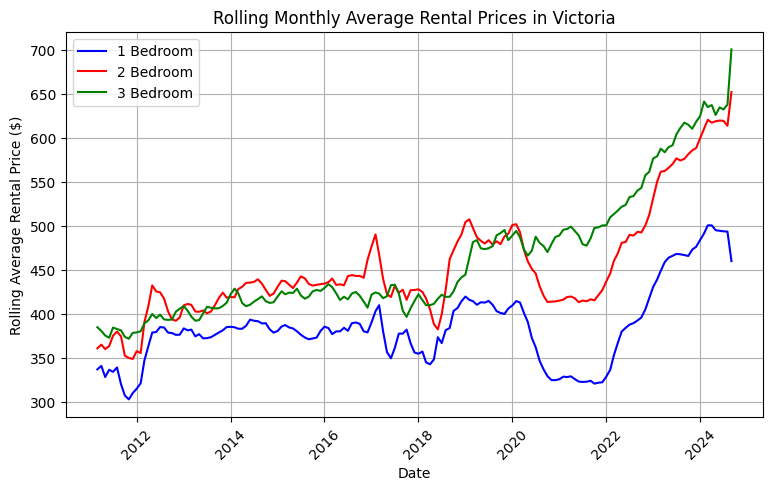

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

pdf = pd.read_parquet("../data/curated/preprocessed_rent_data.parquet")

# Convert 'dateListed' to datetime
pdf['dateListed'] = pd.to_datetime(pdf['date_listed'], errors='coerce')

pdf = pdf[pdf["year"] >= 2011]

# Drop rows with invalid dates
pdf = pdf.dropna(subset=['dateListed'])

# Extract year and month for grouping
pdf['year_month'] = pdf['dateListed'].dt.to_period('M')

# Calculate the average rental price per month for each bedroom type
monthly_avg = pdf.groupby(['year_month', 'bedrooms'])['price'].mean().reset_index()

# Convert 'year_month' back to datetime for plotting
monthly_avg['year_month'] = monthly_avg['year_month'].dt.to_timestamp()

# Calculate rolling average with a window of 3 months
monthly_avg['rolling_avg_price'] = monthly_avg.groupby('bedrooms')['price'].rolling(window=3).mean().reset_index(level=0, drop=True)

# Plotting
plt.figure(figsize=(9, 5))

# Plot for 1-bedroom properties
bedroom_1 = monthly_avg[monthly_avg['bedrooms'] == 1]
sns.lineplot(data=bedroom_1, x='year_month', y='rolling_avg_price', label='1 Bedroom', color='blue')

# Plot for 2-bedroom properties
bedroom_2 = monthly_avg[monthly_avg['bedrooms'] == 2]
sns.lineplot(data=bedroom_2, x='year_month', y='rolling_avg_price', label='2 Bedroom', color='red')

# Plot for 2-bedroom properties
bedroom_3 = monthly_avg[monthly_avg['bedrooms'] == 3]
sns.lineplot(data=bedroom_3, x='year_month', y='rolling_avg_price', label='3 Bedroom', color='green')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Rolling Average Rental Price ($)')
plt.title('Rolling Monthly Average Rental Prices in Victoria')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-ticks for better readability

# Save the plot to a PNG file
plot_path = 'rolling_avg_rental_prices.png'
plt.savefig(plot_path, bbox_inches='tight')
plt.show()


In [27]:
# Optionally, you can save the filtered DataFrame back as Parquet
selected_df.to_parquet('../data/curated/feature_selected_rental_listings.parquet')